In [497]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

plt.rc('font', size=15)


In [498]:
# Overlap-add FIR filter, (c) Joachim Thiemann 2016
# https://github.com/jthiem/overlapadd/blob/master/olafilt.py
#
# modified by WMXZ to work on multi-channel data
#
def fft_filt(b, x, zi=None, nh=0):
    """
    Filter a one-dimensional array with an FIR filter

    Filter a data sequence, `x`, using a FIR filter given in `b`.
    Filtering uses the overlap-add method converting both `x` and `b`
    into frequency domain first.  The FFT size is determined as the
    next higher power of 2 of twice the length of `b`.

    Parameters
    ----------
    b : one-dimensional numpy array
        The impulse response of the filter
    x : one-dimensional numpy array
        Signal to be filtered
    zi : one-dimensional numpy array, optional
        Initial condition of the filter, but in reality just the
        runout of the previous computation.  If `zi` is None or not
        given, then zero initial state is assumed.
    nh : time shift of result (group delay)

    Returns
    -------
    y : array
        The output of the digital filter.
    zf : array, optional
        If `zi` is None, this is not returned, otherwise, `zf` holds the
        final filter delay values.
    """

    if x.ndim==1: x=x.reshape(-1,1)
    if b.ndim==1: b=b.reshape(-1,1)
    L_I = b.shape[0]
    # Find power of 2 larger that 2*L_I (from abarnert on Stackoverflow)
    L_F = 2<<(L_I-1).bit_length()
    L_S = L_F - L_I + 1
    L_sig,N_sig = x.shape
    offsets = range(0, L_sig, L_S)

    # handle complex or real input
    if np.iscomplexobj(b) or np.iscomplexobj(x):
        fft_func = np.fft.fft
        ifft_func = np.fft.ifft
        res = np.zeros((L_sig+L_F,N_sig), dtype=np.complex128)
    else:
        fft_func = np.fft.rfft
        ifft_func = np.fft.irfft
        res = np.zeros((L_sig+L_F,N_sig))

    FDir = fft_func(b, n=L_F,axis=0)

    # overlap and add
    for n in offsets:
        res[n:n+L_F,:] += ifft_func(fft_func(x[n:n+L_S,:], n=L_F,axis=0)*FDir,axis=0)

    if zi is not None:
        res[:zi.shape[0],:] = res[:zi.shape[0],:] + zi
        zi=res[L_sig:,:]
        return res[nh:nh+L_sig,:],zi 
    else:
        return res[nh:nh+L_sig,:]

def hilbert_filt(ss,nh):
    # generate hilbert response (complex valued)
    hk=np.pi*np.arange(-nh,nh+1)
    hk[nh]=1        # to avoid division by 0; will be corrected below
    #
    hh= 0*hk+1j*(1-np.cos(hk))/hk
    hh[nh]=1+1j*0   # correct previous adjustment
    #
    zz=fft_filt(hh,ss,nh=nh)
    return zz

def matched_filt(xx,ss):
    # xx is signal for replica
    # ss us data to be filtered
    #
    # for matched filter
    nd=np.shape(xx)[0]
    rep=np.flipud(xx)/np.sqrt((nd/2*np.sum(xx**2)))
    #
    zz=fft_filt(rep,ss,nh=len(rep)//2)
    return zz
#
def sim_array(yy,fs,DT1,noise):
    # delay signal according to array geometry 
    # (use fractional delay with sinc function)
    kk=np.arange(-10,10,1);
    ss=np.zeros((len(yy),len(DT1)))
    for ii in range(len(DT1)):
        ss[:,ii]=fft_filt(np.sinc(kk+DT1[ii]*fs/1000),yy)[:,0]

    nn=np.random.normal(scale=noise, size=ss.shape)
    ss +=nn
    return ss


## fm modulation

\begin{aligned}y(t)&=A_{c}\cos \left(2\pi \int _{0}^{t}f(\tau )d\tau \right)\\&=A_{c}\cos \left(2\pi \int _{0}^{t}\left[f_{c}+f_{\Delta }x_{m}(\tau )\right]d\tau \right)\\&=A_{c}\cos \left(2\pi f_{c}t+2\pi f_{\Delta }\int _{0}^{t}x_{m}(\tau )d\tau \right)\\\end{aligned}

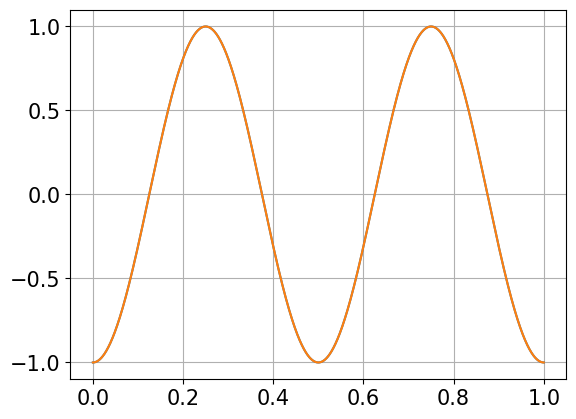

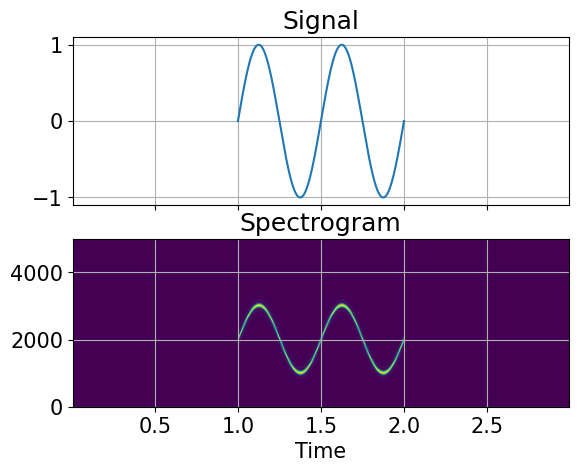

In [499]:
import numpy as np
import matplotlib.pyplot as plt

#%% signal generation
fs = 96000 # sampling frequency
tt = np.arange(0, 1, 1/fs) # time axis

f_sig = 2 # base signal frequency
x_m = np.sin(2*np.pi*f_sig*tt) # base signal
y_m = -np.cos(2*np.pi*f_sig*tt) # integrated base signal
z_m = (2*np.pi*np.cumsum(x_m)/fs-1/f_sig)*f_sig
plt.plot(tt,y_m)
plt.plot(tt,z_m)
plt.grid(True)
plt.show()

#%% modulation
fc = 2000 # carrier frequency
fm = 1000 # modulation t_t = fc +- fm
f_d = fm/f_sig 
#
# phi = 2*pi*(fc*tt + fm*integral(x_m))
phi = 2*np.pi*fc*tt + f_d*z_m # phase

ss = np.sin(phi) # modulated signal

xx=np.concatenate((np.zeros(fs),ss,np.zeros(fs)))

nw=1024
nover=nw//2
nfft=nw*4
f,t,Q0 = signal.spectrogram(xx,fs=fs,nperseg=nw,noverlap=nover,nfft=nfft)#,

ext=[t[0],t[-1],f[0],f[-1]]

#%% plotting
fig, ax = plt.subplots(2, 1, num=0, clear=True, sharex=True)

ax[0].set_title('Signal')
ax[0].plot(1+tt, x_m)
ax[0].grid(True)

ax[1].set_title('Spectrogram')
ax[1].imshow(Q0, origin='lower', aspect='auto',extent=ext)
ax[1].set_ylim(0,5000)
ax[1].grid(True)

ax[1].set_xlabel('Time')
plt.show()


In [500]:
#hydrophone configuration
dz=np.sqrt(0.5)
print(2*dz)
ho=np.array([[1,0,-dz],[-1,0,-dz],[0,-1,dz],[0,1,dz]])*0.0725

isel=np.array([[1,0],[2,0],[3,0],[2,1],[3,1],[3,2]])
D=ho[isel[:,0],:]-ho[isel[:,1],:]
L=np.sqrt(np.sum(D**2,1))
print(L,'m')
print(0.75/L, 'kHz')
DI=np.linalg.pinv(D)

## simulate delay
az=-60*np.pi/180
el= 60*np.pi/180
S=np.array([np.cos(az)*np.cos(el),np.sin(az)*np.cos(el), np.sin(el)])
DC=np.sum(ho*S,1)
DT=DC/1.500   # ms
print(DT, 'ms')



1.4142135623730951
[0.145 0.145 0.145 0.145 0.145 0.145] m
[5.17241379 5.17241379 5.17241379 5.17241379 5.17241379 5.17241379] kHz
[-0.01751467 -0.04168133  0.05052695  0.00866905] ms


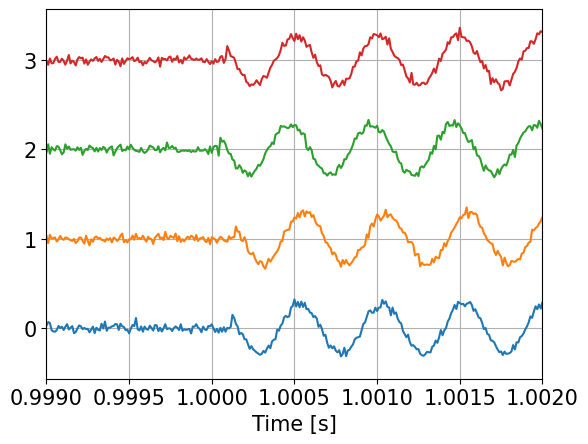

In [501]:
#delay signal according to array geometry
ss=sim_array(xx,fs,DT,0.1)
ts=np.arange(ss.shape[0])/fs
plt.plot(ts,0.4*ss/np.max(ss)+np.ones((ss.shape[0],1))*np.arange(len(DT)));
plt.grid(True)
plt.xlim(1.0-0.001, 1.0+0.002)
plt.xlabel('Time [s]')
plt.show()

## Phase shift method

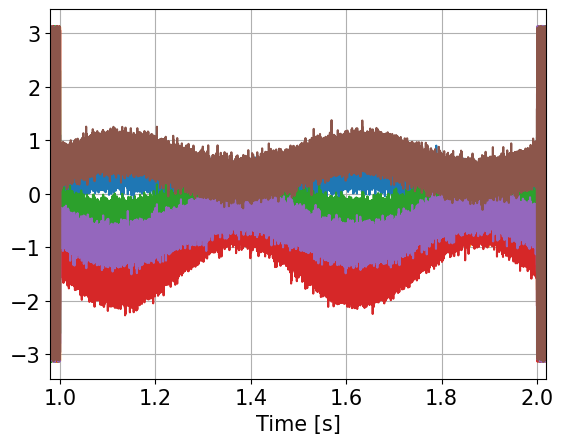

In [502]:
#phase process 
zz=signal.hilbert(ss,axis=0)
#
ns=np.shape(isel)[0]
DPhi=np.zeros((ss.shape[0],ns))
for ii in range(ns):
    DPhi[:,ii]= np.log(zz[:,isel[ii,1]]/zz[:,isel[ii,0]]).imag
#
plt.plot(ts,DPhi)
plt.grid(True)
plt.xlim(1.0-0.02, 2.0+0.02)
plt.xlabel('Time [s]')
plt.show()

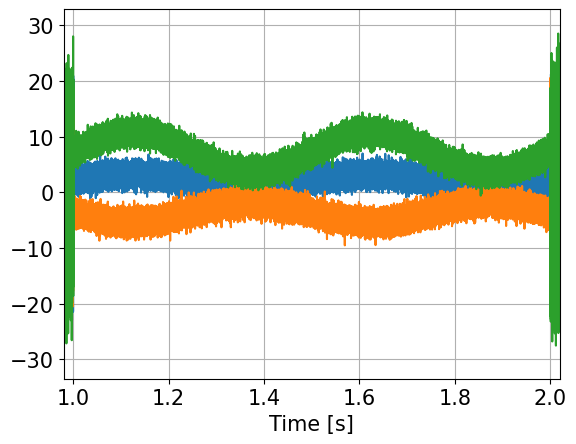

In [503]:
vv=-DPhi@DI.T

plt.plot(ts,vv)
plt.grid(True)
plt.xlim(1.0-0.02, 2.0+0.02)
plt.xlabel('Time [s]')
plt.show()

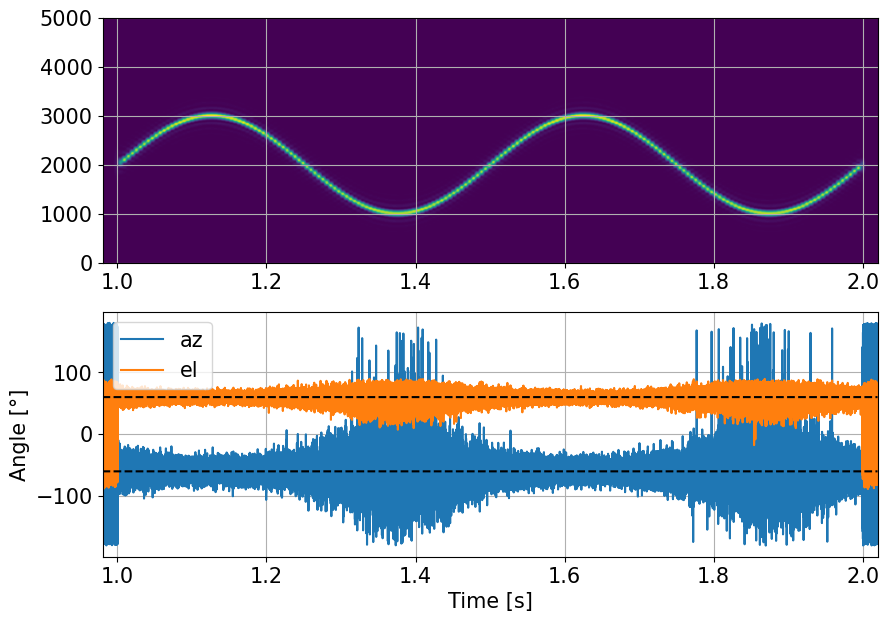

In [504]:
# angle estimation
azx=180/np.pi*np.arctan2(vv[:,1],vv[:,0])
elx=180/np.pi*np.arctan2(vv[:,2],np.sqrt(vv[:,0]**2+vv[:,1]**2))
#
f,t,Q= signal.spectrogram(ss[:,0],fs=fs,nperseg=nw,noverlap=nover,nfft=nfft)#,

ext=[t[0],t[-1],f[0],f[-1]]

plt.figure(figsize=(10,7))
plt.subplot(211)
plt.imshow(Q,origin='lower', aspect='auto',extent=ext)
plt.ylim(0,5000)
plt.grid(True)
plt.xlim(1.0-0.02, 2.0+0.02)
plt.grid(True)

plt.subplot(212)
plt.plot(ts,azx,label='az')
plt.plot(ts,elx,label='el')
plt.plot(ts,180/np.pi*az+0*ts,'k--')
plt.plot(ts,180/np.pi*el+0*ts,'k--')
plt.xlim(1.0-0.02, 2.0+0.02)
plt.grid(True)
#plt.ylim(-10,10)
plt.xlabel('Time [s]')
plt.ylabel('Angle [°]')
plt.legend()
plt.show()


## Spectrogram method

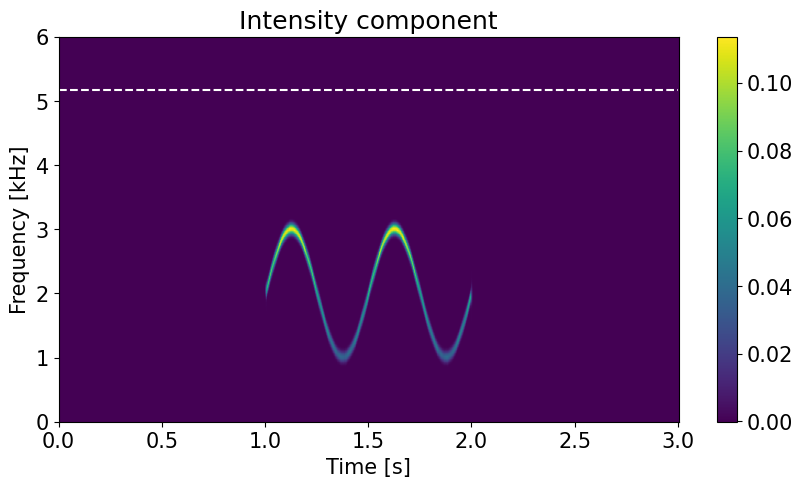

In [505]:
nw=1024
nover=nw//2
nfft=nw*4

f,t,Q=signal.stft(ss,fs=fs,nperseg=nw,noverlap=nover,nfft=nfft,axis=0)
n1,n2,n3=Q.shape

C=np.zeros((n1,n3,ns))
for ii in range(ns):
    C[:,:,ii] = -np.imag(Q[:,isel[ii,0],:]*np.conjugate(Q[:,isel[ii,1],:]))

xl=[0,3]
yl=[0,6]

fig = plt.figure("figsize",[10,5])
plt.imshow(C[:,:,0],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.hlines(np.min(0.75/np.max(L)),0,3,colors='w',linestyles='--')
plt.ylim(yl)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.colorbar()
plt.title('Intensity component')
plt.show()

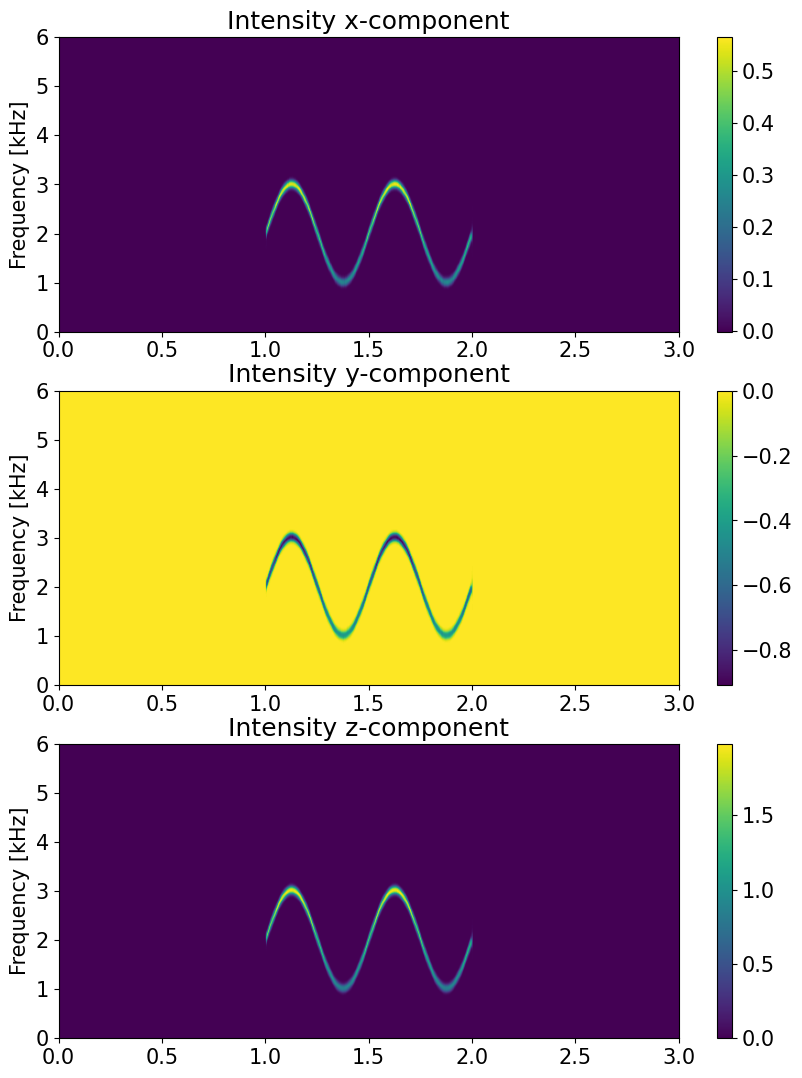

In [506]:
## 3-d summation
I=-C@DI.T
#
xl=[0,3]
yl=[0,6]
fig = plt.figure("figsize",[10,13])
plt.subplot(311)
plt.imshow(I[:,:,0],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.ylim(yl)
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.title('Intensity x-component')
plt.subplot(312)
plt.imshow(I[:,:,1],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.ylim(yl)
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.title('Intensity y-component')
plt.subplot(313)
plt.imshow(I[:,:,2],origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.ylim(yl)
plt.colorbar()
plt.ylabel('Frequency [kHz]')
plt.title('Intensity z-component')
plt.show()

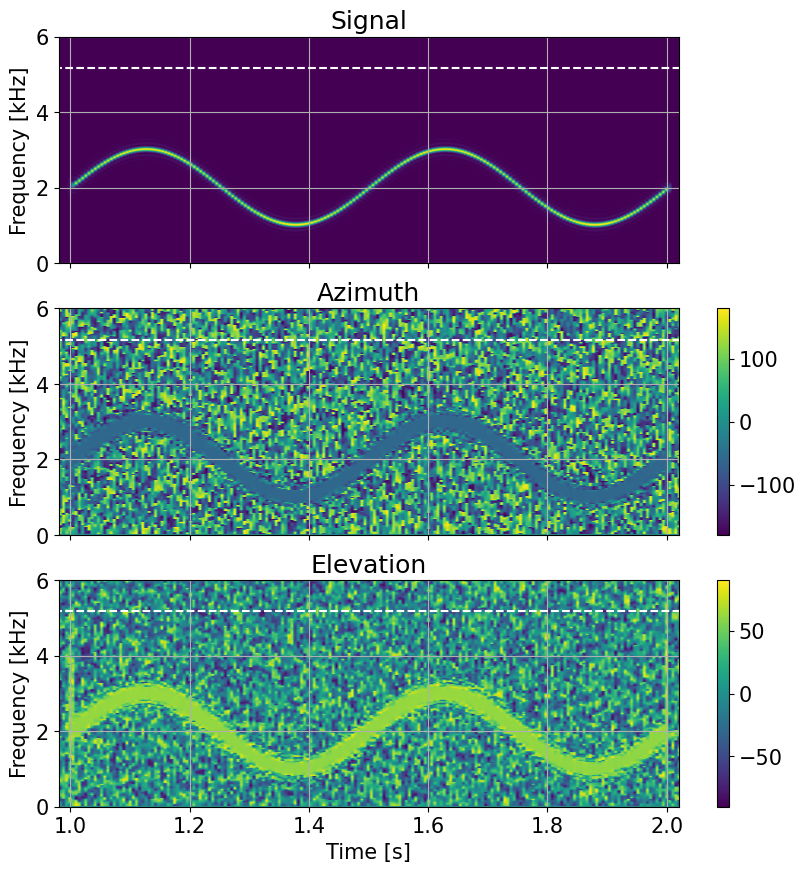

In [509]:
## angle estimations
Azx=180/np.pi*np.arctan2(I[:,:,1],I[:,:,0])
Elx=180/np.pi*np.arctan2(I[:,:,2],np.sqrt(I[:,:,0]**2+I[:,:,1]**2))
#
xl=[1-0.02,2+0.02]
fig = plt.figure("figsize",[10,10])
plt.subplot(311)
plt.imshow(Q0,origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.ylim(yl)
plt.hlines(np.max(0.75/np.max(L)),0,3,colors='w',linestyles='--')
plt.grid(True)
plt.ylabel('Frequency [kHz]')
plt.title('Signal')
#
plt.subplot(312)
plt.imshow(Azx,origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.ylim(yl)
plt.hlines(np.max(0.75/np.max(L)),0,3,colors='w',linestyles='--')
plt.colorbar()
plt.grid(True)
plt.ylabel('Frequency [kHz]')
plt.title('Azimuth')
#
plt.subplot(313)
plt.imshow(Elx,origin='lower', aspect='auto',extent=(t[0],t[-1],f[0]/1000,f[-1]/1000))
plt.xlim(xl)
plt.ylim(yl)
plt.hlines(np.max(0.75/np.max(L)),0,3,colors='w',linestyles='--')
plt.colorbar()
plt.grid(True)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [kHz]')
plt.title('Elevation')
#
axs=fig.get_axes()
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
pos0=axs[0].get_position()
pos1=axs[1].get_position()
pos0.x1 = pos1.x1
axs[0].set_position(pos0)
plt.show()

